In [36]:
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import matplotlib.pyplot as plt
from astropy.table import Table
import ccdproc
from astropy.io import fits
import glob
from photutils import DAOStarFinder
from photutils.detection import IRAFStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import MMMBackground, MADStdBackgroundRMS
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.modeling.fitting import LevMarLSQFitter

Biases:

In [2]:
bias_list = glob.glob('Wolf1346/bias*.fits')

In [3]:
master_bias = ccdproc.combine(bias_list,unit=u.electron)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
np.mean(master_bias)

351.60790918162616

In [5]:
exp_times = []
means = []

for filename in bias_list:
    # Open the FITS file
    hdu = fits.open(filename)
    
    exptime = hdu[0].header['exptime']
    print('Exposure time {} sec'.format(exptime))
    
    # This will append the exposure time for each image to the array
    exp_times.append(exptime)
    
    # Same for mean counts
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means.append(mean_counts)

# Convert to Numpy arrays so they can be sorted
exp_times = np.array(exp_times)
means = np.array(means)

# Sort by exposure time so the plot looks correct
time_sort = np.argsort(exp_times)
exp_times = exp_times[time_sort]
means = means[time_sort]

Exposure time 0 sec
Mean counts: 351.58

Exposure time 0 sec
Mean counts: 351.69

Exposure time 0 sec
Mean counts: 351.68

Exposure time 0 sec
Mean counts: 351.74

Exposure time 0 sec
Mean counts: 351.65

Exposure time 0 sec
Mean counts: 351.40

Exposure time 0 sec
Mean counts: 351.71

Exposure time 0 sec
Mean counts: 351.36

Exposure time 0 sec
Mean counts: 351.70

Exposure time 0 sec
Mean counts: 351.68

Exposure time 0 sec
Mean counts: 351.50



Flats:

In [6]:
domeflat_r_list = glob.glob('arcsat2019/domeflat_sdss_r*.fits')
domeflat_g_list = glob.glob('arcsat2019/domeflat_sdss_g*.fits')
skyflat_B_list = glob.glob('arcsat2019/skyflat_B*.fits')
skyflat_V_list = glob.glob('arcsat2019/skyflat_V*.fits')

In [7]:
master_dome_r = ccdproc.combine(domeflat_r_list,unit=u.electron)
master_dome_g = ccdproc.combine(domeflat_g_list,unit=u.electron)
master_sky_B = ccdproc.combine(skyflat_B_list,unit=u.electron)
master_sky_V = ccdproc.combine(skyflat_V_list,unit=u.electron)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Photometry:

In [8]:
hdu = fits.open('quadRU.fits')[0]  
image = hdu.data.astype(float)     

In [9]:
bkg_sigma = mad_std(image)    
daofind = DAOStarFinder(fwhm=6., threshold=10*bkg_sigma)
sources = daofind(image)
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=5)
phot_table = aperture_photometry(image, apertures) 
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,562.42673568764,1.5587043658607955,0.3538505996183048,0.4903890667133774,-0.8955603762306777,49,0.0,61100.45702202685,447.351946133016,-6.626623327530093
2,172.87518240834083,24.840084362106968,0.4626738818595015,0.22671974132214345,-0.09402184639296064,49,0.0,3875.4178607834847,25.364491712465952,-3.5105654094205625
3,587.6096166536701,36.73646692227233,0.47637624508426,0.20659069800767008,-0.1784218071457466,49,0.0,2162.562941680303,12.613176313396368,-2.7520611664080343
4,550.6110813658258,40.489313815251364,0.5071585612606934,0.2515866745504176,-0.0839269938036004,49,0.0,757.528377357474,3.0456148515260737,-1.2091874539734335
5,10.489770470062894,53.15224089718261,0.4612805224318037,0.24417874735661452,-0.009565508490548841,49,0.0,587.5752775514769,2.368945432311546,-0.9363876426058515
6,306.8811239568398,53.94198326933205,0.46611578040041607,0.09279391314974056,-0.16496316721490445,49,0.0,638.0527134510223,2.6803799316576318,-1.0704908941463191
7,288.1646244771663,58.45103818317468,0.4365138768731693,0.24776503444053816,-0.04674434111851635,49,0.0,653.2369357468882,2.8151937050144746,-1.123770706782482
8,963.7167642803397,60.690711470503636,0.42035584957228717,0.21551060354376866,-0.17385487218480009,49,0.0,685.6352644154877,2.9186110938774856,-1.1629405723146151
9,501.4446796595535,62.76237790935714,0.5063210501325143,0.09779758162486728,-0.10577607578056727,49,0.0,724.1702556488617,2.9928201352254082,-1.190201542663181


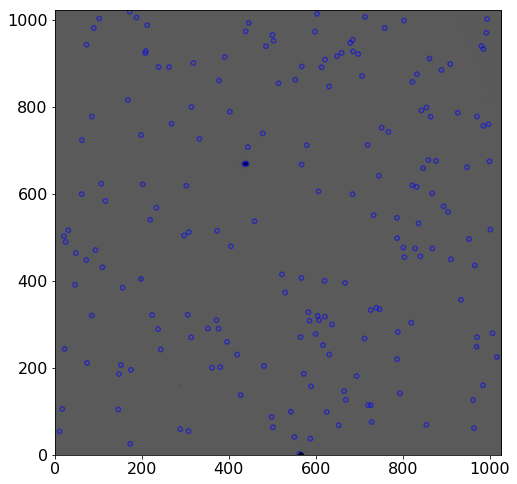

In [10]:
plt.figure(figsize=(8, 10))
plt.rcParams['font.size'] = 16
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image, cmap='Greys',origin='lower',norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [11]:
annulus = CircularAnnulus(positions,3,8)

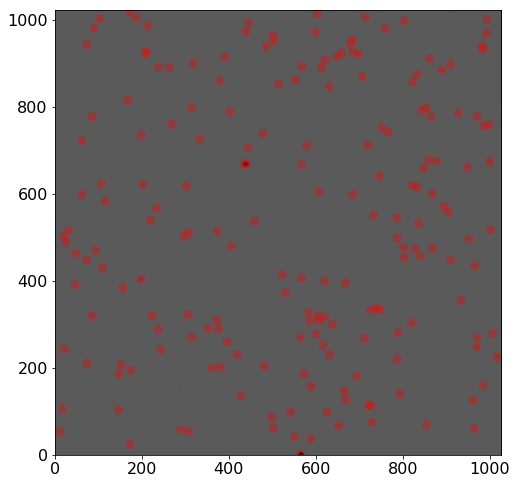

In [12]:
plt.figure(figsize=(8, 10))
plt.rcParams['font.size'] = 16
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image, cmap='Greys',origin='lower',norm=norm)
annulus.plot(color='red', lw=1.5, alpha=0.5)

In [13]:
apers = [apertures, annulus]
phot_table1 = aperture_photometry(image, apers)
bkg_mean = phot_table1['aperture_sum_1'] / annulus.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table1['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
final_sum

1664214.880084074
66666.09792243918
35873.672983975295
8989.056707154552
5944.160544540384
6722.75121233131
7044.08336801294
8138.335083755228
8140.016911820327
7234.561881656566
11540.348409856411


Text(0, 0.5, 'Flux')

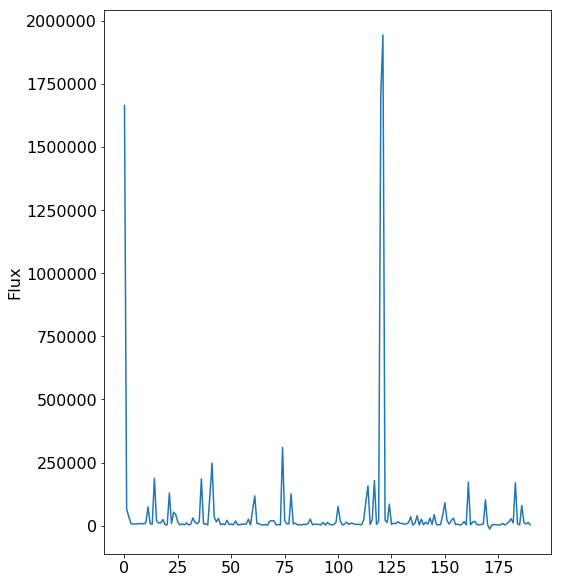

In [14]:
plt.figure(figsize=(8, 10))
plt.rcParams['font.size'] = 16
plt.plot(final_sum)
plt.ylabel('Flux')

In [31]:
psf_model = IntegratedGaussianPRF(sigma=bkg_sigma)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
daogroup = DAOGroup(6)
mmm_bkg = MMMBackground()

pos = Table(names=['x_0', 'y_0'], data=[sources['xcentroid'],
                                        sources['ycentroid']])
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
result_tab = photometry(image=image, init_guesses=pos)
residual_image = photometry.get_residual_image()

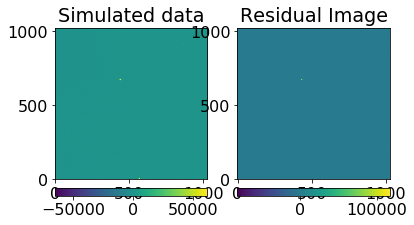

In [32]:
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)